# **Santa trees packing challenge**

**The Challenge**

In this re-defined optimization problem, help Santa fit Christmas tree toys into the smallest (2-dimension) parcel size possible so that he can efficiently mail these stocking stuffers around the globe. Santa needs the dimensions of the smallest possible square box that fits shipments of between 1-200 trees.

**The Model**

The model developped here is a combination of several algorythms:
    - a basic bottom left algorythm,
    - a more comple heuristic model,
    - a simulated annealing algorythm.

**Main Tips**

The reference polygon has the shape of a Christmas tree.

One key idea is that superposing two trees head-to-head allows us to obtain a reference shape with higher compactness. Therefore, this two-tree brick is used as the reference element to fill the square boxes, completed by a single tree in the odd case.

Another important idea is the definition of a new class, ChristmasForest, which allows us to group several trees together and build an envelope polygon. This envelope is then used to significantly reduce CPU computation time during optimization.

In [1]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.1.2


In [2]:
import math
import pdb
from math import inf
import os
import random
from decimal import Decimal, getcontext,ROUND_FLOOR

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon,MultiPolygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.ops import triangulate

import time
import pickle
import copy

import json


pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

In [3]:
# Build the index of the submission, in the format:
#  <trees_in_problem>_<tree_index>

index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

# **New Classes definition**
## class ChristmasTree

In [4]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

## class ChristmasForest

In [5]:
class ChristmasForest:
    """
    Group of polygons (trees) with a global position and rotation.

    Main specific methods:
        - update_coord(): apply the global translation (center_x, center_y)
                          and rotation (angle) to the forest
        - envelope(): compute an envelope polygon of the forest
    """

    def __init__(self, polygons=None, coord=None, center_x='0', center_y='0', angle='0'):

        # -------------------------------------------------
        # Polygons initialization
        # -------------------------------------------------
        if polygons is None:
            self.polygons = []
        else:
            # If polygons are already shapely Polygon objects
            if any(isinstance(t, Polygon) for t in polygons):
                self.polygons = polygons
            else:
                # Otherwise, objects are expected to have a .polygon attribute
                self.polygons = [t.polygon for t in polygons]

        # -------------------------------------------------
        # Local coordinates of each polygon
        # (x, y, angle)
        # -------------------------------------------------
        if coord is None:
            self.coord = [(Decimal(0), Decimal(0), Decimal(0)) for _ in self.polygons]
        else:
            self.coord = coord

        # Global forest transformation
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

    # -----------------------------------------------------
    # TRANSLATION
    # -----------------------------------------------------
    def translate(self, dx, dy):
        dx = Decimal(dx)
        dy = Decimal(dy)

        # Update forest center
        self.center_x += dx
        self.center_y += dy

        # Translate polygons
        self.polygons = [
            affinity.translate(
                poly,
                xoff=float(dx * scale_factor),
                yoff=float(dy * scale_factor)
            )
            for poly in self.polygons
        ]

        # Update local coordinates
        self.coord = [(x + dx, y + dy, a) for (x, y, a) in self.coord]

    # -----------------------------------------------------
    # ROTATION (around the origin)
    # -----------------------------------------------------
    def rotate(self, angle_deg):
        angle_deg = Decimal(angle_deg)
        self.angle += angle_deg

        cx = 0.0
        cy = 0.0

        # Rotate polygons
        self.polygons = [
            affinity.rotate(poly, float(angle_deg), origin=(cx, cy))
            for poly in self.polygons
        ]

        # Rotate coordinates
        new_coord = []
        for (x, y, a) in self.coord:
            pt = Point(float(x), float(y))
            new_pt = affinity.rotate(pt, float(angle_deg), origin=(cx, cy))
            new_coord.append(
                (Decimal(new_pt.x), Decimal(new_pt.y), a + angle_deg)
            )

        self.coord = new_coord

    # -----------------------------------------------------
    # APPLY GLOBAL TRANSFORMATION
    # -----------------------------------------------------
    def update_coord(self):
        """
        Apply the global rotation and translation to the forest,
        then reset the global transformation parameters.
        """
        self.rotate(self.angle)
        self.translate(self.center_x, self.center_y)

        # Reset forest transformation
        self.center_x = Decimal(0.0)
        self.center_y = Decimal(0.0)
        self.angle = Decimal(0.0)

        return self.coord

    # -----------------------------------------------------
    # ENVELOPE
    # -----------------------------------------------------
    def envelope(self, ntol=1):
        """
        Compute an envelope polygon of the forest.

        A small buffer is applied to merge nearly touching polygons,
        then removed to recover an approximate original shape.
        """

        # Step size for final optimization
        eps = 0.001e15

        # 1. Merge polygons using a small buffer
        merged = unary_union([poly.buffer(eps) for poly in self.polygons])

        # 2. Remove buffer and simplify geometry
        merged = merged.buffer(-eps)
        merged = merged.simplify(
            tolerance=eps * ntol,
            preserve_topology=True
        )

        if isinstance(merged, Polygon):
            return Polygon(merged.exterior)
        else:
            # MultiPolygon case
            return merged


## class ChristmasBlock

In [6]:
class ChristmasBlock:
    """
    Group of polygons (or trees) with their corresponding coordinates.

    This class is a simple container that stores:
        - a list of polygons
        - a list of associated coordinates (x, y, angle)
    """

    def __init__(self, polygons=None, coord=None):

        # -------------------------------------------------
        # Polygons
        # -------------------------------------------------
        if polygons is None:
            self.polygons = []
        else:
            # If the input already contains Polygon objects
            if any(isinstance(t, Polygon) for t in polygons):
                self.polygons = polygons
            else:
                # Otherwise, assume objects with a `.polygon` attribute
                self.polygons = [t.polygon for t in polygons]

        # -------------------------------------------------
        # Local coordinates for each polygon
        # -------------------------------------------------
        if coord is None:
            # Initialize coordinates to (0, 0, 0) for each polygon
            # (x, y, rotation angle)
            self.coord = [
                (Decimal(0), Decimal(0), Decimal(0))
                for _ in self.polygons
            ]
        else:
            self.coord = coord


# **Utils**

## creation_block

In [7]:
def creation_block(placed, coord, side, tol=0.2):
    """
    Split polygons into two blocks:
    - blocked polygons: strictly inside the square
    - unblocked polygons: touching (or close to) the square boundary
    """

    # *************************************
    # 1. Group polygons by their Y centroid
    # *************************************
    groups = {}

    for poly, c in zip(placed, coord):
        # Y coordinate of centroid (scaled and rounded for stability)
        # y = round(float(poly.centroid.y), 14)   # native unit (unused)
        y = round(poly.centroid.y / float(scale_factor), 1)
        groups.setdefault(y, []).append((poly, c))

    # Lists for boundary (limit) and inner (block) polygons
    limit_polygons = []
    limit_coords = []
    block_polygons = []
    block_coords = []

    sc = float(scale_factor)

    # *************************************
    # 2. Detect polygons close to the square boundary
    # *************************************
    for poly, t in zip(placed, coord):
        _, _, mx, my = poly.bounds

        # Check if polygon touches (or is close to) the right or top boundary
        if (
            abs(float(mx) - side) <= tol * side
            or abs(float(my) - side) <= tol * side
        ):
            limit_polygons.append(poly)
            limit_coords.append(t)
        else:
            block_polygons.append(poly)
            block_coords.append(t)

    # *************************************
    # 3. Create ChristmasBlock objects
    # *************************************
    blocked = ChristmasBlock(block_polygons, block_coords)
    unblocked = ChristmasBlock(limit_polygons, limit_coords)

    return blocked, unblocked

## Plot debug

In [8]:
def plot_debug(placed_trees):
    plt.figure(figsize=(5,5))
    for t in placed_trees:
        x, y = t.polygon.exterior.xy
        plt.fill(x, y, color='green', alpha=0.5)
        plt.plot(x, y, color='darkgreen')
    # candidate_poly est un Shapely Polygon   
    plt.axis('equal')  # pour garder les proportions
    plt.title("Candidate Tree Polygon")
    plt.show()
    
    # DEbug
    pdb.set_trace()

## Square side computation

### Square

In [9]:
    def loss_func(s,n):
        score=0
        for i in range(n):
            score+=s[i]*s[i]/(i+1)
        return score 

In [10]:
 def loss_func_2(s,n,offset):
        score=0
        for i in range(n):
            score+=s[i]*s[i]/(i+1+offset)
        return score 

## box_dim

In [11]:
def box_dim(placed_trees):
    if any(isinstance(t, Polygon) for t in placed_trees):
        all_polygons = placed_trees
    else:
        all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # this forces a square bounding using the largest side
    side_length = max(width, height)
    return side_length,width,height
    

## plot_polygons

In [12]:
# ---- Fonctions utilitaires ----

def plot_polygons(polys):
    if (isinstance(polys[0],ChristmasForest)) or (isinstance(polys[0],ChristmasBlock)):
        all_polygons = [poly for t in polys for poly in t.polygons]
    elif any(isinstance(t, Polygon) for t in polys):
        all_polygons = polys
    elif all(isinstance(e, tuple) for e in polys):
        all_polygons = []
        for coord in polys:
            all_polygons.append(ChristmasTree(center_x=coord[0],
                                              center_y=coord[1],
                                             angle=coord[2]).polygon)
    else:
        all_polygons = [t.polygon for t in polys]

        
    bounds = unary_union(all_polygons).bounds

    minx = bounds[0] / float(scale_factor)
    miny = bounds[1] / float(scale_factor)
    maxx = bounds[2] / float(scale_factor)
    maxy = bounds[3] / float(scale_factor)
    fig, ax = plt.subplots(figsize=(6,6))
    scale_plot=1e15

    
    # Tracer les polygones
    for poly in all_polygons:
        x, y = poly.exterior.xy
        poly_scaled = [(xi/scale_plot, yi/scale_plot) for xi, yi in zip(x, y)]
        patch = MplPolygon(poly_scaled, closed=True, facecolor='orange', edgecolor='red', alpha=0.5)
        ax.add_patch(patch)
    for i, (px, py) in enumerate(list(poly.exterior.coords)[:-1]):
        plt.text(px/float(scale_factor), py/float(scale_factor), str(i), fontsize=12, color='red', ha='right')
    # ax.set_xlim(0, side)
    # ax.set_ylim(0, side)
    side=max(maxx-minx,maxy-miny)
    ax.set_xlim(minx, minx+side)
    ax.set_ylim(miny, miny+side)
    plt.title("title")

    
    plt.show()
    print('Side', side)

##  Build_Forest from result file

In [13]:
def build_forest(coord,imode=1):
    # From a formatted data dedicated to submission file
    # build the forest corresponding to nb_tree tree
    # * coord : vector of results in the format of submission file
    # * nb_tree : number of tree (if nb_tree is None, only one forest in coord)
    nb_poly=1
    ntotpoly=0
    theforest=[]
    side_list=[]
    list_coord=[]

    while ntotpoly<len(coord):
        
        theforest.append([ChristmasTree(center_x=x,center_y=y,angle=a).polygon 
                            for x,y,a in coord[ntotpoly:ntotpoly+nb_poly]])
        list_coord.append([[x,y,a] for x,y,a in coord[ntotpoly:ntotpoly+nb_poly]])
        
        side,_,_=box_dim(theforest[-1])
        side_list+=[side]
        
        ntotpoly+=nb_poly
        nb_poly+=1

    score=loss_func(side_list,len(side_list))

    return theforest,list_coord,score,side_list
    
    
    

## replace_forest

In [14]:
def replace_forest(santa):
    """
    Translate a forest so that its minimum x and y coordinates
    are moved to the origin (0, 0).

    Parameters
    ----------
    santa : ChristmasBlock
        Block containing polygons and their coordinates.

    Returns
    -------
    ChristmasBlock
        Translated block with updated polygons and coordinates.
    """

    # Find the minimum x and y bounds among all polygons
    minx = min(poly.bounds[0] for poly in santa.polygons)
    miny = min(poly.bounds[1] for poly in santa.polygons)

    # Translate polygons so that the forest starts at (0, 0)
    poly_santa = [
        affinity.translate(poly, xoff=-minx, yoff=-miny)
        for poly in santa.polygons
    ]

    # Update coordinates accordingly (converted back using scale_factor)
    coord_santa = [
        (
            x - Decimal(minx) / scale_factor,
            y - Decimal(miny) / scale_factor,
            a
        )
        for (x, y, a) in santa.coord
    ]

    # Create a new ChristmasBlock with updated data
    santa_clauss = ChristmasBlock(poly_santa, coord_santa)

    return santa_clauss


## overlap_test

In [15]:
def overlap_test(record_coord, imode=1):
    """
    Check for polygon overlaps based on recorded coordinates.

    If imode == 1:
        - Interpret record_coord as multiple test cases
          with an increasing number of trees per test.
    If imode == 0:
        - Interpret record_coord as a single test case.
    """

    if imode:
        nbp = 0
        nbf = 1

        # Compute how many test cases are encoded in record_coord
        while nbp < len(record_coord):
            nbp += nbf
            nbf += 1

        test_polygons = []   # Final list containing lists of polygons
        index = 0            # Current index in record_coord

        # Build test cases with an increasing number of trees
        for nb_trees in range(1, nbf):
            case_polygons = []

            for _ in range(nb_trees):
                x, y, a = record_coord[index]
                poly = ChristmasTree(center_x=x, center_y=y, angle=a).polygon
                case_polygons.append(poly)
                index += 1

            test_polygons.append(case_polygons)

        # Collision check for each test case
        for test_id, polys in enumerate(test_polygons, start=1):

            if len(polys) <= 1:
                continue  # No collision possible with one polygon

            tree = STRtree(polys)

            for i, poly in enumerate(polys):
                # STRtree also returns the polygon itself → must be filtered out
                near_indices = tree.query(poly)

                for j in near_indices:
                    if j == i:
                        continue  # Ignore self-intersection

                    other = polys[j]

                    # Strict intersection means a collision
                    if poly.intersects(other) and not poly.touches(other):
                        print(
                            f"Collision detected in test {test_id} "
                            f"between objects {i} and {j}"
                        )
                        break

    else:
        # Single test case mode
        polys = []

        for x, y, a in record_coord:
            poly = ChristmasTree(center_x=x, center_y=y, angle=a).polygon
            polys.append(poly)

        tree = STRtree(polys)

        for i, poly in enumerate(polys):
            # STRtree also returns the polygon itself → must be filtered out
            near_indices = tree.query(poly)

            for j in near_indices:
                if j == i:
                    continue  # Ignore self-intersection

                other = polys[j]

                # Strict intersection means a collision
                if poly.intersects(other) and not poly.touches(other):
                    print(
                        f"Collision detected in test "
                        f"between objects {i} and {j}"
                    )
                    break

    print("End of collision check")


## scale_record_coord

In [16]:
def scale_record_coord(record_coord, eps=1e-5):
    """
    Scale the coordinates of a record by a given factor.

    Parameters:
        record_coord: list of tuples/lists
            Each element is (x, y, angle) representing a polygon/tree position.
        eps: float
            Scaling factor (default is 1e5).

    Returns:
        scaled: list
            List of scaled coordinates with the same structure as input.
    """

    scaled = []  # Initialize list for scaled coordinates

    for x, y, a in record_coord:
        # Scale x and y by (1 + eps)
        new_x = x * Decimal(1 + eps)
        new_y = y * Decimal(1 + eps)
        
        # Append scaled coordinate with original angle
        scaled.append([new_x, new_y, a])

    return scaled

# **Bottom left Algorythm**

## Final_opti utils : move_dx and move_dy

In [17]:
def move_dx(moved,poly,tree,dy):
    """ move_dx is used to move a polygon to the left of the box
    There are 2 steps:
        - first step Backward move until collision
        - second step Forward move until no collision
    """
    #*************************************************************
    stepx1=0.1e15
    while stepx1<11e15: 
    # Backward move dx until collision
          
        moved = affinity.translate(poly, xoff=-stepx1, yoff=dy)

        # looking for collision 
        near_indices = tree.query(moved)
        near = [tree.geometries[i] for i in near_indices]
        collision = any(moved.intersects(p) and not moved.touches(p) for p in near)
        if collision:
            break
        minx, _,_,_ = moved.bounds
        collision = (minx<0)
        if collision:
            break
        stepx1+=0.1e15
    #*************************************************************
    stepx2=0.002e15
    while stepx2<1e15:
    # Forward move dx until no collision
        
        moved = affinity.translate(poly, xoff=-stepx1+stepx2, yoff=dy)

        # looking for collision 
        near_indices = tree.query(moved)
        near = [tree.geometries[i] for i in near_indices]
        collision = any(moved.intersects(p) and not moved.touches(p) for p in near)
        if not collision:
            minx, _,_,_ = moved.bounds
            collision = (minx<0)
        if not collision:
            break
        stepx2+=0.002e15
    dx=-stepx1+stepx2
    return moved,dx
    #*************************************************************


def move_dy(moved,poly,tree,dx):
    """ move_dy is used to move a polygon to the bottom of the box
    There are 2 steps:
        - first step Backward move until collision
        - second step Forward move until no collision
    """
    #*************************************************************
    stepy1=0.1e15
    while stepy1<11e15:
    # Backward x
        moved = affinity.translate(poly, xoff=dx, yoff=-stepy1)
        near_indices = tree.query(moved)
        near = [tree.geometries[i] for i in near_indices]
        collision = any(moved.intersects(p) and not moved.touches(p) for p in near)
        if collision:
            break
        _, miny,_,_ = moved.bounds
        collision = (miny<0)
        if collision:
            break
        stepy1+=0.1e15
    #*************************************************************
    stepy2=0.002e15
    while stepy2<1e15:
    # Forward
        moved = affinity.translate(poly, xoff=dx, yoff=-stepy1+stepy2)
        near_indices = tree.query(moved)
        near = [tree.geometries[i] for i in near_indices]
        collision = any(moved.intersects(p) and not moved.touches(p) for p in near)
        if not collision:
            _, miny,_,_ = moved.bounds
            collision = (miny<0)
        if not collision:
            break
        stepy2+=0.002e15
    dy=-stepy1+stepy2
    return moved,dy


## Final opti forest

In [18]:
def final_opti_forest(placed, coord, isort=0):
    """
    Final optimization step for forest packing.
    Polygons are reordered and shifted to reduce empty space.
    """

    # -------------------------------------------------
    # The first element must not move (odd & even case)
    # -------------------------------------------------
    final_placed = [placed[0]]
    final_move = [coord[0]]

    move_poly = placed[1:]
    move_coord = coord[1:]

    # -------------------------------------------------
    # 1) Sort polygons by centroid x + y
    # -------------------------------------------------
    def centroid_sum(poly):
        x, y = poly.centroid.coords[0]
        return x + y

    index = list(range(len(move_poly)))

    if isort == 0:
        # Sort ascending
        sorted_indices = sorted(index, key=lambda i: centroid_sum(move_poly[i]))
    else:
        # Sort descending
        sorted_indices = sorted(
            index,
            key=lambda i: centroid_sum(move_poly[i]),
            reverse=True
        )

    sorted_polys = [move_poly[i] for i in sorted_indices]
    move_coord = [move_coord[i] for i in sorted_indices]

    # -------------------------------------------------
    # 2) Initialize local placement lists
    # -------------------------------------------------
    all_polys = list(sorted_polys)
    local_placed = []
    local_move = []

    # -------------------------------------------------
    # 3) First vertical move (Y direction)
    # -------------------------------------------------
    for idx, poly in enumerate(sorted_polys):

        # Initial polygon bounds
        minx, miny, maxx, maxy = poly.bounds

        # Other polygons used for collision detection
        others = [p for p in all_polys if p is not poly] + final_placed

        # Spatial index for collision detection
        tree = STRtree(others)

        dx = 0
        dy = 0

        # Vertical movement only
        moved, dy = move_dy(poly, poly, tree, dx)

        # Store moved polygon
        final_placed.append(moved)
        local_move.append((Decimal(0), Decimal(dy) / scale_factor, Decimal(0)))

        # Remove processed polygon
        try:
            all_polys.remove(poly)
        except ValueError:
            # Should not happen, but ignored safely
            pass

    # -------------------------------------------------
    # Update coordinates after first move
    # -------------------------------------------------
    local_move = [
        tuple(x + y for x, y in zip(t1, t2))
        for t1, t2 in zip(move_coord, local_move)
    ]

    final_move += local_move

    # -------------------------------------------------
    # 4) Group polygons by vertical columns (X value)
    # -------------------------------------------------
    move_poly = final_placed[1:]
    move_coord = final_move[1:]

    block_placed = [final_placed[0]]
    block_move = [final_move[0]]

    groups = {}

    for poly, c in zip(move_poly, move_coord):

        # Stable numeric key without floating-point errors
        x = (Decimal(poly.centroid.x) / Decimal(scale_factor)).quantize(
            Decimal("0.1"),
            rounding=ROUND_FLOOR
        )

        groups.setdefault(x, []).append((poly, c))

    # Sort columns from left to right
    sorted_groups = sorted(groups.items(), key=lambda t: t[0])

    # -------------------------------------------------
    # 5) Build envelopes for each vertical line
    # -------------------------------------------------
    ligne = []
    theforest = []

    for _, items in sorted_groups:
        poly_only = [p for (p, _) in items]
        theforest.append(ChristmasForest(polygons=poly_only))

    imove = True

    for forest in theforest:
        env = forest.envelope(ntol=2.5)

        if isinstance(env, Polygon):
            ligne.append(env)
        elif isinstance(env, MultiPolygon):
            ligne.append(env)
            # Disable movement if multipolygon detected
            imove = False

    # -------------------------------------------------
    # 6) Second horizontal move (X direction)
    # -------------------------------------------------
    if imove:

        second_move = []
        all_polys = list(ligne)
        local_placed = []

        for env in ligne:

            others = (
                [p for p in all_polys if p is not env]
                + local_placed
                + block_placed
            )

            tree = STRtree(others)

            # Horizontal movement only
            moved, dx = move_dx(env, env, tree, dy=0)

            local_placed.append(moved)

            try:
                all_polys.remove(env)
            except ValueError:
                pass

            second_move.append(
                (Decimal(dx) / scale_factor, Decimal(0), Decimal(0))
            )

        # -------------------------------------------------
        # 7) Rebuild final placed polygons
        # -------------------------------------------------
        second_placed = []

        for forest, (dx, _, _) in zip(theforest, second_move):
            forest.center_x += dx
            forest.update_coord()
            second_placed.extend(forest.polygons)

        # -------------------------------------------------
        # 8) Update coordinates after second move
        # -------------------------------------------------
        dx_list = [dx for (dx, _, _) in second_move]

        updated_coords = []
        for (_, items), dx in zip(sorted_groups, dx_list):
            for poly, c in items:
                cx, cy, angle = c
                updated_coords.append((cx + dx, cy, angle))

        final_move = block_move + updated_coords
        final_placed = block_placed + second_placed

    return final_placed, final_move


## Final opti

In [19]:
def final_opti(placed,coord,isort=0,iord=0):
    """ final_opti is a bottom-left algorythm. 
    Input :
        -placed: list of polygons
        -coord : coordinated of polygons (submission format)
        -isort : boolean to define how to sort the polygons before move
        -iord : boolean to define how to move the polygons (dx vs dy)
    Output : 
        -final_placed: lists of optimized polygons
        -final-move: lists of optimized coordinate
    """
    # 1) Trier les polygones selon x_cent + y_cent
    def centroid_sum(poly):
        x, y = poly.centroid.coords[0]
        return x + y

    index = list(range(len(placed)))

    
    if isort==0: # Sort the polygons from the smallest distance to (0,0)
        sorted_indices = sorted(index, key=lambda i: centroid_sum(placed[i]))
    else:# Sort the polygons from the longest distance to (0,0)
        sorted_indices = sorted(index, key=lambda i: centroid_sum(placed[i]),reverse=True)
        
    sorted_polys = [placed[i] for i in sorted_indices]
    coord = [coord[i] for i in sorted_indices]

    final_placed = list(sorted_polys)
    final_move=[]

    # Loop on the polygons to optimze their positions 
    # ************************************************
    for idx, poly in enumerate(sorted_polys):        

        minx, miny, maxx, maxy = poly.bounds

        # List of polygons different from poly
        others = [p for i, p in enumerate(final_placed) if i != idx]        
        # STRtree used to pre-compute local geomtry useful to optimize
        # collision check
        tree = STRtree(others)

        step1x=0
        step2x=0
        step1y=0
        step2y=0
        dx=0
        dy=0
        
        if iord==0: # Fist optimization move dx and so dy
            moved,dx=move_dx(poly,poly,tree,dy)
            moved,dy=move_dy(poly,poly,tree,dx)
        else: # First optimization move dy and so dx
            moved,dy=move_dy(poly,poly,tree,dx)
            moved,dx=move_dx(poly,poly,tree,dy)
        
        # Computation of the moved polygon
        final_placed[idx] = moved
        final_move.append((Decimal(dx)/scale_factor,
                           Decimal(dy)/scale_factor,Decimal(0)))
        
        # End of the loop
        # **************************************************************
    
    # Storage of the coordinate
    final_move = [tuple(x + y for x, y in zip(t1, t2)) 
                  for t1, t2 in zip(coord, final_move)]

    
    return final_placed, final_move

# **Heuristic Algorythm**
## Utils : candidate position

In [20]:
def candidate_positions(placed):
    """
    Return a set of candidate (x, y) positions based on the vertices
    of already placed polygons and some additional reference points
    along the axes.
    """

    # Set used to avoid duplicate candidate positions
    pts = set()

    # Loop over all already placed polygons
    for poly in placed:

        # Pre-selected indices of polygon vertices used as candidates
        # (hard-coded heuristic for performance / relevance)
        index = [0, 2, 3, 5, 6, 15, 16, 20, 22, 23, 25, 26, 35]

        # Iterate over selected vertex indices
        for i in index:
            # Add vertex coordinates as Decimal tuples
            pts.add((Decimal(x[i]), Decimal(y[i])))

    # Define range for additional candidate positions
    min_step = 0
    max_step = 50

    # Add candidate positions along the X axis (y = 0)
    pts.update(
        (Decimal(i * 0.1) * scale_factor, Decimal(0))
        for i in range(min_step, max_step)
    )

    # Add candidate positions along the Y axis (x = 0)
    pts.update(
        (Decimal(0), Decimal(i * 0.1) * scale_factor)
        for i in range(min_step, max_step)
    )

    # Return the full set of candidate positions
    return pts

## try_pack_opti

In [21]:
def try_pack_opti2(unplaced, blocked, ref, box_size, angles, ibool, iforest, pol_ref):
    """
    Try to pack polygons using a greedy heuristic with rotation,
    collision detection, and optional final optimization.

    Input:
        -unplaced: lists of polygons to move
        - blocked : list of polygons placed
        - ref: pre-computed reference brick
        - angles : rotation angle
        - ibool : main loop index
        - iforest : if unplaced list of forest or basic tree
        - pol_ref : pre-computed rotated reference brick
    Output:
        - placed: list of optimized polygons
        - coord : list of optimized coordinate
    """

    # -------------------------------------------------
    # 1) Re-initialize unplaced polygons and coordinates
    # -------------------------------------------------
    n = len(unplaced.polygons)
    unplaced.polygons = [ref] * n
    unplaced.coord = [(Decimal(0.0), Decimal(0.0), Decimal(0.0))] * n

    polygons = unplaced.polygons

    # -----------------------------------------
    # 2) Initialization of placed polygons
    # -----------------------------------------
    if blocked:
        placed = blocked.polygons
        coord = blocked.coord
        tree = STRtree(placed)     # Spatial index for fast collision queries
    else:
        placed = []
        coord = []
        tree = None

    # Global bounding box (used when ibool == 0)
    global_minx = inf
    global_miny = inf
    global_maxx = -inf
    global_maxy = -inf

    offset = 1e11

    # *****************************************
    # 3) Main algorithm: loop over polygons
    # *****************************************
    for ipol in range(n):

        # Best solution found for the current polygon
        best_poly = None
        best_score = inf
        best_score2 = inf
        best_ang = None
        best_dx = None
        best_dy = None

        # -------------------------------------
        # Candidate positions generation
        # -------------------------------------
        if iforest:
            if placed:
                # Use corners of bounding boxes of already placed polygons
                positions = [
                    corner
                    for (bx, by, Bx, By) in (t.bounds for t in placed)
                    for corner in [
                        (bx, by),   # xmin, ymin
                        (Bx, by),   # xmax, ymin
                        (bx, By),   # xmin, ymax
                        (Bx, By)    # xmax, ymax
                    ]
                ]
            else:
                positions = [(Decimal(0), Decimal(0))]
        else:
            if placed:
                positions = candidate_positions(placed)   
            else:
                positions = [
                    (Decimal(0.) * scale_factor, Decimal(0.) * scale_factor),
                    (Decimal(0.) * scale_factor, Decimal(0.2) * scale_factor),
                    (Decimal(0.35) * scale_factor, Decimal(0.) * scale_factor),
                ]

        # -------------------------------------
        # Loop over precomputed rotations
        # -------------------------------------
        for ang in angles:

            # Envelope of the rotated polygon (precomputed in pack_min_rectangle)
            rotated = ChristmasForest(pol_ref[ang][0]).envelope()

            if not iforest:
                minx_box, miny_box, _, _ = rotated.bounds
                index = [0, 1, 3, 5, 7, 8, 10, 12, 14, 1000]
            else:
                index = [0]
                new_box = [rotated.bounds]

            x, y = rotated.exterior.xy

            # ---------------------------------
            # Loop over reference points
            # ---------------------------------
            for i in index:
                if iforest:
                    minx_rot, miny_rot, _, _ = new_box[i]
                else:
                    if i < 1000:
                        minx_rot, miny_rot = rotated.exterior.coords[i]
                    else:
                        minx_rot, miny_rot = minx_box, miny_box

                # ---------------------------------
                # Loop over candidate positions
                # ---------------------------------
                for (px, py) in positions:
                    dx = float(px) - minx_rot
                    dy = float(py) - miny_rot

                    moved = affinity.translate(rotated, dx, dy)

                    # Check if inside the positive quadrant
                    if ibool >= 0:
                        mnx, mny, mxx, mxy = moved.bounds
                        if mnx < 0 or mny < 0:
                            continue

                    # Collision detection
                    if tree is not None:
                        near_indices = tree.query(moved)
                        near = [tree.geometries[i] for i in near_indices]

                        collision = any(
                            moved.intersects(p) and not moved.touches(p)
                            for p in near
                        )

                        if collision:
                            continue

                    # ---------------------------------
                    # Scoring function
                    # ---------------------------------
                    if ibool >= 0:
                        toto = placed + [moved]

                        minx = min(p.bounds[0] for p in toto)
                        miny = min(p.bounds[1] for p in toto)
                        maxx = max(p.bounds[2] for p in toto)
                        maxy = max(p.bounds[3] for p in toto)

                        # Square side length
                        score = max(maxx - minx, maxy - miny)

                    # Best score update
                    if score < best_score:
                        mnx, mny, _, _ = moved.bounds
                        score2 = mnx + mny  # Bottom-left preference

                        best_score = score
                        best_score2 = score2
                        best_poly = moved
                        best_ang = ang
                        best_dx = dx
                        best_dy = dy

                    elif score <= 1.0001 * best_score:
                        mnx, mny, _, _ = moved.bounds
                        score2 = mnx + mny

                        if score2 < best_score2:
                            best_score = score
                            best_score2 = score2
                            best_poly = moved
                            best_ang = ang
                            best_dx = dx
                            best_dy = dy

        # -------------------------------------
        # Failure if no placement was found
        # -------------------------------------
        if best_poly is None:
            print("Polygone missing")
            return None, coord

        # -------------------------------------
        # Update global bounding box
        # -------------------------------------
        mnx, mny, mxx, mxy = best_poly.bounds
        global_minx = min(global_minx, mnx)
        global_miny = min(global_miny, mny)
        global_maxx = max(global_maxx, mxx)
        global_maxy = max(global_maxy, mxy)

        # -------------------------------------
        # Update placed polygons and spatial tree
        # -------------------------------------
        placed.append(best_poly)
        tree = STRtree(placed)

        # Store final coordinates using Decimal
        coord.append((
            unplaced.coord[ipol][0] + Decimal(best_dx + offset) / scale_factor,
            unplaced.coord[ipol][1] + Decimal(best_dy + offset) / scale_factor,
            unplaced.coord[ipol][2] + Decimal(best_ang)
        ))

    # *****************************************
    # End of main loop on polygons
    # *****************************************

    coord_new = coord

    # *****************************************
    # 4) Final optimization phase
    # Bottom-left algorythm
    # *****************************************
    if ibool >= 0:
        if iforest:
            placed, coord = final_opti_forest(placed, coord, isort=0)
        else:
            placed, coord = final_opti(placed, coord, isort=0, iord=1)
            placed, coord = final_opti(placed, coord, isort=1, iord=1)
            placed, coord = final_opti(placed, coord, isort=0, iord=0)
            placed, coord = final_opti(placed, coord, isort=1, iord=0)

    # *****************************************
    # End of final optimization
    # *****************************************

    return placed, coord


# **Main algorythm manager**
## pack_min_square

In [22]:
def pack_min_square(pack_tree, blocked=None, tol=1e12, pol_ref=None):
    """
    pack_min_square is the main algorithm manager

    There are 2 main loop indexed with ibool:
        -each loop, try_pack_opti() is called,  a greedy heuristic algorythm,
        -in the second loop, different angle of rotation allowed
        -in the second loop, some polygons are "blocked", only a part of polygons
        moves
        -at last, the bottom-left alogorythm final_opti() is called to optimize results

    Input:
        - pack_tree : trees to be moved
        - blocked   : already placed trees
        - tol       : tolerance for square side convergence
        - pol_ref   : pre-computed rotated reference brick

    Output:
        - packed     : optimized moved trees
        - side       : square side
        - best_coord : coordinates of moved polygons
    """

    packed = []
    unplaced = []
    coord = []

    # --------------------------------------------------
    # Check the format of pack_tree
    # --------------------------------------------------
    if isinstance(pack_tree[0], ChristmasForest):
        # Forest mode: use envelopes to limit number of vertex
        polygons = [t.envelope() for t in pack_tree]
        iforest = True
    else:
        # Standard polygon mode
        polygons = [t.polygon for t in pack_tree]
        iforest = False

    # --------------------------------------------------
    # Reference polygon (used as base)
    # --------------------------------------------------
    ref = polygons[0]

    # --------------------------------------------------
    # Handle blocked polygons (already placed)
    # --------------------------------------------------
    if blocked:  # Special configuration: first polygon already placed
        coord.append(blocked.coord)
        len_block = len(blocked.polygons)
    else:
        len_block = 0

    # Initialize coordinates for all polygons
    for t in polygons:
        coord.append((Decimal(0), Decimal(0), Decimal(0)))

    # --------------------------------------------------
    # Polygon validity check
    # --------------------------------------------------
    for i, p in enumerate(polygons):
        if not p.is_valid:
            return None, f"Polygon {i} is invalid"

    # --------------------------------------------------
    # Base polygon bounding box
    # --------------------------------------------------
    base = polygons[0]
    bx, by, Bx, By = base.bounds
    polysize = max(Bx - bx, By - by)

    if polysize <= 0:
        return None, "Invalid polygon size"

    # --------------------------------------------------
    # Search interval for square side
    # --------------------------------------------------
    min_side = polysize / 2
    max_side = polysize * 40  # Huge margin

    best_result = None

    # --------------------------------------------------
    # Main optimization loop
    # --------------------------------------------------
    for ibool in range(0, 2):

        # ----------------------------------------------
        # Rotation angle selection
        # ----------------------------------------------
        if iforest:
            if ibool == 0: # First loop : no rotation allowed
                angles = [0]
            else: # Second loop: one rotation allowed
                angles = [0, 90]
        else:
            angles = list(range(0, 360, 90))  # Finer resolution

        # Stop early if configuration is not compatible
        if ibool > 0 and not iforest:
            break

        # Mid-point of the current interval
        mid = (min_side + max_side) / 2

        # Initialize unplaced block if needed
        if not unplaced:
            unplaced = ChristmasBlock(polygons, coord)

        # ----------------------------------------------
        # Try packing with current square size
        # ----------------------------------------------
        attempt, coord = try_pack_opti2(
            unplaced,
            blocked,
            ref,
            mid,
            angles,
            ibool,
            iforest,
            pol_ref
        )

        if attempt is not None:
            # Successful packing
            best_result = attempt
            best_coord = coord

            max_side, _, _ = box_dim(best_result)
            max_side = float(max_side * scale_factor)

            if iforest:
                blocked, unplaced = creation_block(
                    best_result,
                    best_coord,
                    max_side
                )
        else:
            # Packing failed → increase minimum size
            min_side = mid

        # Convergence check
        if max_side - min_side < tol:
            break

    # --------------------------------------------------
    # No valid packing found
    # --------------------------------------------------
    if best_result is None:
        return None, "No packing found for any size"

    # --------------------------------------------------
    # Update packed polygons
    # --------------------------------------------------
    for i in range(len(pack_tree) + len_block):
        has_negative = any(
            x < 0 or y < 0
            for x, y in best_result[i].exterior.coords
        )
        if has_negative:
            print("Negative coordinate", has_negative)

        packed.append(best_result[i])

    # --------------------------------------------------
    # Final square dimension
    # --------------------------------------------------
    side, _, _ = box_dim(packed)

    return packed, side, best_coord


## pack_min_rectangle

In [23]:
def pack_min_rectangle(pack_tree, angles=None,rot_init=0, tol=1e12):
    """ pack_min_rectangle computes the optimized configuration of 2 trees
    in the smallest rectangle. Then, once is done. pack-min rectangle
    pre-computes all the rotated configuration composed the optimized 2 trees
    It returns:
        - pol_ref[ang] : storage of rotated polygons
        - side : smallest square side of the optimized 2 trees configuration
        - compacity: indicator on rectangle compacity
    """
    polygons=[(t.polygon) for t in pack_tree]
    if angles is None:
        angles = [0,180]
    # Polygons check
    for i,p in enumerate(polygons):
        if not p.is_valid:
            return None, f"Polygon {i} is invalid"
    # bounding box of the polygon
    base = polygons[0]
    bx, by, Bx, By = base.bounds
    polysize = max(Bx - bx, By - by)
    
    nn=len(initial_poly)
    # ----------------------------------------------------
    # 1) Build of the reference brick composed by 2 trees
    # ----------------------------------------------------
    pol_ref={}

    best_poly = []
    best_score = inf
    best_ang = 0
    best_dx = 1e15
    best_dy = 1e15
    coord = []
    polygons_ref=[]
    ang=0
    for ipol,poly in enumerate(polygons): 
        
        # Basic rectangle assembling
        # Rotation of trees
        if ipol%2 == 0:
            best_ang=180         
        else:
            best_ang=0
            
        angle_key = (best_ang+rot_init) % 360

        poly= affinity.rotate(polygons[0], angle_key, origin=(0, 0))
        
        # Initial large translation of trees before otpimisation
        polygons_ref.append(affinity.translate(poly, xoff=best_dx, yoff=best_dy))
        coord.append((
            Decimal(best_dx) / scale_factor,
            Decimal(best_dy) / scale_factor,
            Decimal(angle_key)
        ))
        
        best_dx+=1e15
        best_dy+=1e15

    # Optimization of polygons position using a bottom-left algorythm
    polygons_ref, coord=final_opti(polygons_ref,coord,isort=0,iord=1)

    # Storage of reference polygon and its coordinates at ang=0
    pol_ref[ang]=(polygons_ref,coord)

    # -----------------------------------------------------------------------
    # 2) Pre_compute all rotated position of the brick to optimize CPU cost
    # ----------------------------------------------------------------------

    # Loop every 5 degrees and storage of all the polygons in pol_ref
    poly=[None]*len(polygons)
    for ang in range(5, 360, 5):
        polygons_ref=[]
        coord=[]
         
        poly = [affinity.rotate(pol_ref[0][0][ipol], ang, origin=(0, 0)) 
                     for ipol in range(len(polygons))]

        # Position of rotated box
        minx = min(p.bounds[0] for p in poly)
        miny = min(p.bounds[1] for p in poly)
        
        for ipol in range(len(polygons)):
            # Initial rotation
            if ipol%2 == 0:
                best_ang=180         
            else:
                best_ang=0
            angle_key = (best_ang+rot_init+ang) % 360
            
            # Translation to (0,0) position   
            # Initial translation
            polygons_ref.append(affinity.translate(poly[ipol], xoff=-minx, yoff=-miny))
            
            # Translation computed from the center of rotation 
            # (mid of the segment between vertex #6 and #9)
            vertex=polygons_ref[ipol].exterior.coords
            
            best_dx=(vertex[6][0]+vertex[9][0])/2
            best_dy=(vertex[6][1]+vertex[9][1])/2
            
            coord.append((
                Decimal(best_dx) / scale_factor,
                Decimal(best_dy) / scale_factor,
                Decimal(angle_key)
            ))
            
        # Storage of all rotated polygons in pol_ref
        pol_ref[ang]=(polygons_ref,coord)
        
    # Optimisation Move
    final_placed=pol_ref[0][0]

    # Box dimension calculation: square and rectangle sides
    side,width,height=box_dim(final_placed)

    # Criteria of rectangle compacity
    compacity=width*height/nn
    
    return pol_ref,side,compacity

# **Simulated Annealing Algorythm**
## simulated annealing utils

In [24]:
# ------------------------------
# Cost function
# ------------------------------
def cost(polys):
    """
    Compute a global cost for a set of polygons.

    The cost penalizes:
    - negative coordinates
    - strict polygon collisions
    - large bounding square size
    """

    penalty = 0

    # -------------------------------------------------
    # 1) Collision detection using a spatial index
    # -------------------------------------------------
    tree = STRtree(polys)

    for i, poly in enumerate(polys):

        # Check for negative coordinates
        coords = list(poly.exterior.coords)
        if any(x < 0 or y < 0 for x, y in coords):
            penalty += 1e4
            return penalty

        # Query nearby polygons
        near_indices = tree.query(poly)

        for j in near_indices:
            if j == i:
                continue  # Ignore self-intersection

            other = polys[j]

            # Strict intersection → collision
            if poly.intersects(other) and not poly.touches(other):
                penalty += 1e4
                return penalty

    # -------------------------------------------------
    # 2) Bounding box size penalty
    # -------------------------------------------------
    side_length, width, height = box_dim(polys)

    penalty += float(side_length ** 2) / len(polys)

    return penalty


# ***************************************************************
# Pairwise overlap cost
# ***************************************************************
def overlap_cost(poly1, poly2):
    """
    Return a binary overlap cost between two polygons.
    """

    if poly1.intersects(poly2) and not poly1.touches(poly2):
        return 1.0

    return 0.0


# ***************************************************************
# Incremental cost variation
# ***************************************************************
def delta_cost(polys, idx, new_poly):
    """
    Compute the cost difference if polys[idx] is replaced by new_poly.
    """

    old_poly = polys[idx]
    d_old = 0
    d_new = 0

    for j, poly in enumerate(polys):
        if j == idx:
            continue

        d_old += overlap_cost(old_poly, poly)
        d_new += overlap_cost(new_poly, poly)

    return d_new - d_old


## simul_anneal

In [25]:
def simul_anneal(
    woody,
    T_init=10.0,
    T_min=1,
    alpha=0.99,
    steps_per_T=50
):
    """
    Simulated annealing optimization for packing trees.

    Parameters
    ----------
    woody : ChristmasBlock
        Initial block of trees with coordinates.
    T_init : float
        Initial temperature.
    T_min : float
        Minimum temperature.
    alpha : float
        Cooling rate.
    steps_per_T : int
        Number of iterations per temperature step.

    Returns
    -------
    best_woody : ChristmasBlock
        Best found configuration.
    polys : list
        Final list of polygons.
    """

    # Create a list of trees from initial coordinates
    forest = [
        ChristmasTree(center_x=x, center_y=y, angle=a)
        for x, y, a in woody.coord
    ]

    polys = [t.polygon for t in forest]
    coords = list(woody.coord)

    T = T_init

    # Initial cost based on bounding box size
    side_length, width, height = box_dim(polys)
    best_cost = side_length**2 / len(polys)

    best_polys = list(polys)
    best_coords = list(coords)

    current_cost = cost(best_polys)

    toto=0
    # Main simulated annealing loop
    while T > T_min:

        for _ in range(steps_per_T):

            new_polys = polys[:]
            new_coords = coords[:]

            # Choose a random polygon
            idx = random.randint(0, len(polys) - 1)
            c = polys[idx]

            # Generate a small random move
            dx = Decimal(random.uniform(-0.15, 0.15) * T / T_init)
            dy = Decimal(random.uniform(-0.15, 0.15) * T / T_init)
            da = Decimal(random.uniform(-20.0, 20.0) * T / T_init)

            # Skip negligible moves
            if abs(dx) < 1e-4 and abs(dy) < 1e-4 and abs(da) < 1e-2:
                continue

            # Backup old values
            old_poly = c
            old_coord = coords[idx]

            new_x = coords[idx][0] + dx
            new_y = coords[idx][1] + dy
            new_a = coords[idx][2] + da

            # Apply the move
            new_poly = ChristmasTree(
                center_x=new_x,
                center_y=new_y,
                angle=new_a
            ).polygon

            new_coord = [new_x, new_y, new_a]

            new_polys[idx] = new_poly
            new_coords[idx] = new_coord

            # Compute new cost
            new_cost = cost(new_polys)
            delta = new_cost - current_cost

            # Acceptance criterion (greedy version)
             # if delta < 0.001 * current_cost : 
            if delta<10: # no collision
                # pdb.set_trace()
                test=(random.random()< math.exp(-delta / T)/50)
                if test:
                    toto+=1
                if (delta < 0.001 * current_cost) or test:
                    polys = new_polys[:]
                    coords = new_coords[:]
                    current_cost = new_cost
    
                    # # Update the best solution
                    # if new_cost < best_cost:
                    best_polys = new_polys[:]
                    best_coords = new_coords[:]
                    best_cost = current_cost

        # Cooling step
        T *= alpha

    # Storage of solution
    best_woody = ChristmasBlock(best_polys, best_coords)

    print('toto',toto)

    return best_woody, polys

# Main Execution Code 

In [26]:

# start = time.time()  # timestamp avant le code
# side_list=[]
# side_list_sa=[]
# tree_data_loc = []
# bloc_list=[]
# coord_new=[]
# coord_new2=[]
# final_forest=[]
# inter_forest=[]
# record_coord_inter=[]
# angle_init=66

# # *******************************************************************
# # STEP 1 : Definition of an optimized basic brick composed by 2 trees
# # 
# # *********************************************************************

# for n in [1]:
#     initial_poly = [ChristmasTree() for _ in range(n+1)]
    
#     pol_ref,side,comp = pack_min_rectangle(initial_poly,rot_init=angle_init)
    
# # ChristmasForest is a specific object wich allows to store several trees
# # and to compute an envelope, very usefull to optimized the number of vertex
# basic_rectangle=ChristmasForest(polygons=pol_ref[0][0])
# basic_rectangle_90=ChristmasForest(polygons=pol_ref[300][0])

# # Check of pol_ref
# print("pol_ref")
# plot_polygons(basic_rectangle.polygons)
# # Check of the envelope
# plot_polygons([basic_rectangle.envelope()])



# # ****************************************************************
# # STEP 3 : Main algorythm loop 
# # *****************************************************************

# # Start the main loop with 2 trees
# # Init for partial computation
# inter_forest=[]
# final_forest=[]
# side_list=[]
# side_list_sa=[]
# record_coord=[]

# # Main loop  to iterate on 199 box, the first one is already computed

# for n in range(1,10):

#     # Progress indicator
#     if (n+1) % 5 ==0 : print(n)
        
#     # Creation of trees using the optimized reference 2-trees block 
#     initial_forest=[ChristmasForest(polygons=pol_ref[0][0]) for _ in range(math.floor((n+1)/2))]

#     if (n+1)%2==0: # number of trees is even
#         odd_block=[]
#     else:         # number of trees is odd : need to add a tree
        
#         # Creation of the first tree
#         n_iref=1
#         ang=270
#         t0=ChristmasTree(center_x=0.,center_y=0.,angle=ang).polygon
#         minx,miny,maxx,maxy = t0.bounds
#         t1=ChristmasTree(center_x=-Decimal(minx)/scale_factor,
#                          center_y=-Decimal(miny)/scale_factor,
#                          angle=Decimal(ang)).polygon
        
#         # Storage of the First Tree
#         # Christmas object is usefull for storage of polygons and coordinate
#         odd_block=ChristmasBlock([t1],coord=[(-Decimal(minx)/scale_factor,
#                                               -Decimal(miny)/scale_factor,
#                                               Decimal(ang))])

#     #*********************************************************************************
#     # Main Algorythm : Bottom-Left
#     # *******************************************************************************
#     packed2,side2,coord2 = pack_min_square(initial_forest,blocked=odd_block,pol_ref=pol_ref)
#     side_list.append(side2)
#     # Storage of result
#     inter_forest.extend(packed2)
    
#     # Coordinate Reconstruction
#     coord_ref=pol_ref[0][1]
#     if (n+1)%2==0: # even case
#         reconstruct_coord=[(x + xr, y + yr, ar) for x, y, a in coord2 for xr, yr, ar in pol_ref[a][1]]
#     else:# odd case
#         reconstruct_coord=[coord2[0]] # First tree
#         reconstruct_coord.extend([(x + xr, y + yr, ar) for x, y, a in coord2[1:] for xr, yr, ar in pol_ref[a][1]])
#     # Polygons reconstruction to validation
#     reconstruct_poly=[]
#     for x,y,a in reconstruct_coord:
#         reconstruct_poly.append(ChristmasTree(x,y,a))
    
#     # *******************************
#     # Simulated Annealing Algorythm
#     # ********************************
    
#     # WARNING : valable pour 1 seul cas
#     woody=ChristmasBlock(reconstruct_poly,reconstruct_coord)
  
#     # basic simulated annealing algorythm
#     santa,test=simul_anneal(woody)

#     # Ensure the position of the forest close to the origin (0,0)
#     santa_clauss=replace_forest(santa)

#     # New step of basic bottom-left optiization
#     final_poly,final_coord=final_opti(santa_clauss.polygons,santa_clauss.coord,isort=0,iord=1)   
    
#     side3,_,_=box_dim(final_poly)
#     side_list_sa.append(side3)
#     final_forest.append(final_poly)   

#     # Record of the results in record_coord (submission format)
#     record_coord_inter.extend(reconstruct_coord)
#     record_coord.extend(final_coord)



# # Format of record_coord for submissions
# record_coord=[[a,b,c%360] for (a,b,c) in record_coord]

# dx=Decimal(0)
# dy=Decimal(0)
# for x,y,_ in record_coord:
#     dx = min(dx,x)
#     dy = min(dy,y)

# record_record = [[x+dx,y+dy,a] for x,y,a in record_coord]

# # Scale record_coord to avoid numerical devices
# record_coord=scale_record_coord(le5)

# # Validation of record_coord construction
# anglet=[]
# reconstruct=[]
# for (x,y,a) in record_coord:
#     reconstruct.append(ChristmasTree(center_x=x,center_y=y,angle=a).polygon)
#     anglet.append(a)    

# # Check of collision from record_coord
# overlap_test(record_coord,imode=1)

# # Print some results
# print('Polygone packed2')
# plot_polygons(packed2)
# # print('polygone reconstruct')
# # plot_polygons(reconstruct)
# print('final_poly')
# plot_polygons(final_poly)


# # ****************
# # Final Result
# # *****************
# score_opti=loss_func(side_list,len(side_list))
# print("Score before simul-Anneal",score_opti)

# score_opti_sa=loss_func(side_list_sa,len(side_list_sa))
# print("Score after simul-anneal",score_opti_sa)

# end = time.time()
# duration_minutes = (end - start) / 60
# print(f"Duration : {duration_minutes:.3f} minutes")

# **Second phase Execution Code**

## Loading previous results files

In [27]:
record_coord=[]

with open("/kaggle/input/christmass-version-23/record_coord_1_50.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_51.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_52_100.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_101.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_102_150.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_151_180.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))
with open("/kaggle/input/christmass-version-23/record_coord_180_200.pkl", "rb") as f:
    record_coord.extend(pickle.load(f))

# Ensure to get positive coordinate
eps=Decimal(1e-5)
for idx,[x,y,a] in enumerate(record_coord):
    record_coord[idx]=[x+eps,y+eps,a]

# Scale record_coord to help simulated annealing
record_coord=scale_record_coord(record_coord,eps)

# Reconstruct list of polygons
theforest,list_coord,score,side_list=build_forest(record_coord,imode=1)


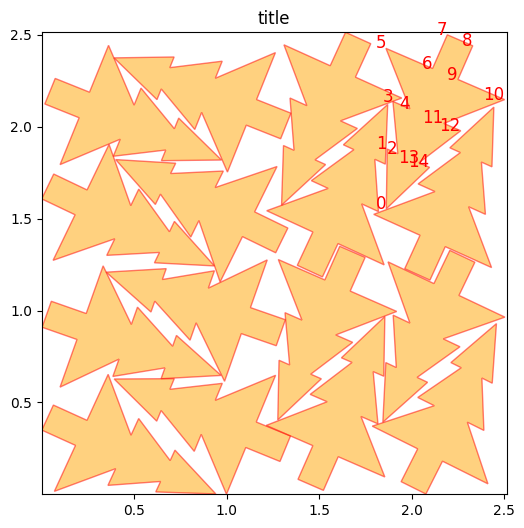

Side 2.5144542087229156


In [28]:
plot_polygons(theforest[15])

## New step of simulated Annealing

In [29]:
# **** Provisoire ****
print(side_list[:20])
# Scale record_coord to help simulated annealing
record_coord=scale_record_coord(record_coord,1e-5)
# Reconstruct list of polygons
theforest,list_coord,_,_=build_forest(record_coord,imode=1)

[Decimal('0.813172798364529625'), Decimal('0.9512086042586308125'), Decimal('1.254395720127974375'), Decimal('1.29719581506663615625'), Decimal('1.5947724947876635625'), Decimal('1.66676000500925425'), Decimal('1.8079783367291670625'), Decimal('1.8306720329063060'), Decimal('1.97755656658398359375'), Decimal('2.110521508879662375'), Decimal('2.19745647819210525'), Decimal('2.2558819474247606875'), Decimal('2.35275956162510015625'), Decimal('2.39532633772392159375'), Decimal('2.4857410027359138125'), Decimal('2.51445420872291575'), Decimal('2.81163260646043125'), Decimal('2.84865391017363203125'), Decimal('2.9390766896276354375'), Decimal('2.93720297921357825')]


In [30]:
start = time.time()

table_santa=[]

# for idx in range(1,21) :
for idx in [15]:

    print(idx)

    woody=ChristmasBlock(theforest[idx],list_coord[idx])
      
    santa,test=simul_anneal(woody, T_init=10.0, T_min=1, alpha=0.99, 
                            steps_per_T=5000)
    

    table_santa.append(santa)
    
plot_polygons([santa])

end = time.time()
duration_minutes = (end - start) / 60
print(f"Duration : {duration_minutes:.3f} minutes")

15


KeyboardInterrupt: 

# **Submission**

In [ ]:

tree_data=record_coord

cols = ['x', 'y', 'deg']
submission = pd.DataFrame(
    index=index, columns=cols, data=tree_data).rename_axis('id')

for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)
    
# To ensure everything is kept as a string, prepend an 's'
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission.to_csv('sample_submission.csv')

# **Utils : Files management**

In [ ]:
# with open("record_coord_180_200.pkl", "wb") as f:
#     pickle.dump(record_coord, f)

# pour recharger, adapter le path
# with open("record_coord.pkl", "rb") as f:
#     record_coord = pickle.load(f)